# import libraries

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2

In [2]:
current_dir = os.getcwd()
wesad_data = {}

for subject in os.listdir():
    subject_path = os.path.join(os.getcwd(), subject)

    if os.path.isdir(subject_path):  
        for file in os.listdir(subject_path):
            if file.endswith(".pkl"):
                pkl_file_path = os.path.join(subject_path, file)

                with open(pkl_file_path, "rb") as f:
                    data = pickle.load(f, encoding="latin1")

                wesad_data[subject] = data

print(wesad_data.keys())

dict_keys(['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9'])


## Target (labels): at 700 HZ
- 0 = Not defined
- 1 = Baseline
- 2 = Stress (Main focus!)
- 3 = Amusement
- 4 = Meditation
- 5/6/7 = ignore
> Final Task: Predict if the subject is Stress(2) ,or Normal (1,3,4)

### RespiBAN (Chest-Worn Sensor) – 700 Hz
- ECG, EDA, EMG, TEMP, RESPIRATION, ACC (XYZ)
### Empatica E4 (Wrist-Worn Sensor)
- ACC → 32 Hz
- BVP → 64 Hz
- EDA → 4 Hz
- TEMP → 4 Hz

> i will work with chest data bec they all at 700 HZ

In [5]:
data_list = []

for subject, data in wesad_data.items():
    chest_data = data["signal"]["chest"]
    labels = data["label"]

    df_chest = pd.DataFrame({
        "ECG": chest_data["ECG"].flatten(),
        "EDA": chest_data["EDA"].flatten(),
        "EMG": chest_data["EMG"].flatten(),
        "TEMP": chest_data["Temp"].flatten(),
        "RESP": chest_data["Resp"].flatten(),
        "ACC_X": chest_data["ACC"][:, 0],
        "ACC_Y": chest_data["ACC"][:, 1],
        "ACC_Z": chest_data["ACC"][:, 2],
        "Label": labels.flatten()[:len(chest_data["ECG"])]  
    })

    df_chest["Subject"] = subject

    data_list.append(df_chest)

df= pd.concat(data_list, ignore_index=True)

In [7]:
df

,ECG,EDA,EMG,TEMP,RESP,ACC_X,ACC_Y,ACC_Z,Label,Subject
0,-1.333694,0.716019,-0.013687,33.695862,0.213623,1.1278,0.1520,0.3416,0,S10
1,-1.327744,0.714493,-0.021927,33.741333,0.192261,1.0932,0.1888,0.2922,0,S10
2,-1.322067,0.715637,-0.009018,33.717072,0.205994,1.0354,0.2094,0.1858,0,S10
3,-1.316345,0.714874,-0.002380,33.741333,0.193787,0.9666,0.2118,0.0412,0,S10
4,-1.310257,0.715256,0.001053,33.747406,0.172424,0.8916,0.2040,-0.1228,0,S10
...,...,...,...,...,...,...,...,...,...,...
60807595,0.369095,3.517532,0.000595,34.767700,-2.662659,0.9274,-0.0178,-0.1274,0,S9
60807596,0.341446,3.530502,-0.009567,34.860077,-2.662659,0.9252,-0.0154,-0.1220,0,S9
60807597,0.262253,3.530502,-0.015152,34.838531,-2.671814,0.9226,-0.0118,-0.1234,0,S9
60807598,0.147263,3.520966,0.008240,34.866211,-2.659607,0.9194,-0.0098,-0.1246,0,S9


# EDA

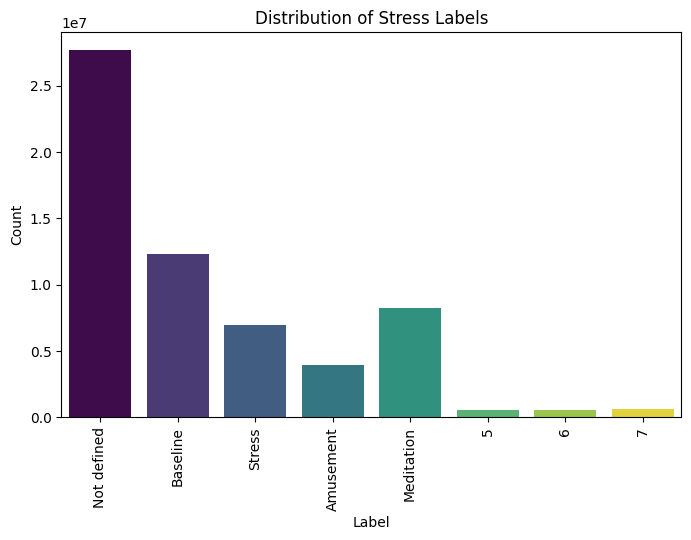

In [7]:
label_mapping = {
    0: "Not defined",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "5",
    6: "6",
    7: "7"
}

plt.figure(figsize=(8, 5))

# Assigning hue to fix the warning
sns.countplot(x=df["Label"], hue=df["Label"], palette="viridis", legend=False)

plt.xticks(ticks=list(label_mapping.keys()), labels=list(label_mapping.values()), rotation=90)

plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Stress Labels")

plt.show()

In [9]:
df = df[df["Label"].isin([1, 2, 3,4])]

In [12]:
df

,ECG,EDA,EMG,TEMP,RESP,ACC_X,ACC_Y,ACC_Z,Label,Subject
65000,-0.006775,0.730515,0.013596,33.891632,0.685120,0.8986,0.0874,-0.2018,1,S10
65001,-0.002884,0.745773,0.015198,33.881012,0.712585,0.8994,0.0882,-0.2008,1,S10
65002,-0.002289,0.755310,0.016800,33.873383,0.737000,0.8978,0.0870,-0.2022,1,S10
65003,0.002792,0.722885,-0.002243,33.893158,0.740051,0.9000,0.0866,-0.1994,1,S10
65004,0.008560,0.728989,-0.007416,33.900757,0.733948,0.9002,0.0870,-0.1990,1,S10
...,...,...,...,...,...,...,...,...,...,...
60712567,0.124008,2.827835,-0.013596,34.856995,5.279541,0.4296,0.0106,-0.8658,4,S9
60712568,0.124283,2.841949,-0.001694,34.847748,5.308533,0.4290,0.0094,-0.8638,4,S9
60712569,0.126389,2.842331,-0.004440,34.850800,5.345154,0.4318,0.0094,-0.8718,4,S9
60712570,0.128494,2.831650,-0.003067,34.856995,5.281067,0.4328,0.0086,-0.8726,4,S9


In [10]:
df['Label'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

C:\Users\USER\AppData\Local\Temp\ipykernel_10728\717121567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)


In [14]:
df

,ECG,EDA,EMG,TEMP,RESP,ACC_X,ACC_Y,ACC_Z,Label,Subject
65000,-0.006775,0.730515,0.013596,33.891632,0.685120,0.8986,0.0874,-0.2018,0,S10
65001,-0.002884,0.745773,0.015198,33.881012,0.712585,0.8994,0.0882,-0.2008,0,S10
65002,-0.002289,0.755310,0.016800,33.873383,0.737000,0.8978,0.0870,-0.2022,0,S10
65003,0.002792,0.722885,-0.002243,33.893158,0.740051,0.9000,0.0866,-0.1994,0,S10
65004,0.008560,0.728989,-0.007416,33.900757,0.733948,0.9002,0.0870,-0.1990,0,S10
...,...,...,...,...,...,...,...,...,...,...
60712567,0.124008,2.827835,-0.013596,34.856995,5.279541,0.4296,0.0106,-0.8658,0,S9
60712568,0.124283,2.841949,-0.001694,34.847748,5.308533,0.4290,0.0094,-0.8638,0,S9
60712569,0.126389,2.842331,-0.004440,34.850800,5.345154,0.4318,0.0094,-0.8718,0,S9
60712570,0.128494,2.831650,-0.003067,34.856995,5.281067,0.4328,0.0086,-0.8726,0,S9


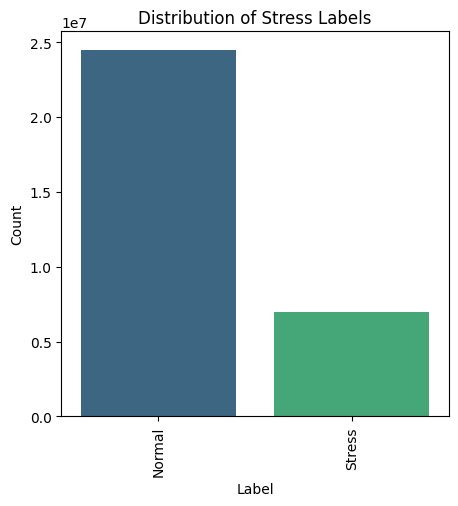

In [15]:
label_mapping = {
    0: "Normal",
    1: "Stress",

}

plt.figure(figsize=(5, 5))
sns.countplot(x=df["Label"], hue=df["Label"], palette="viridis", legend=False)

plt.xticks(ticks=list(label_mapping.keys()), labels=list(label_mapping.values()), rotation=90)

plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Stress Labels")

plt.show()

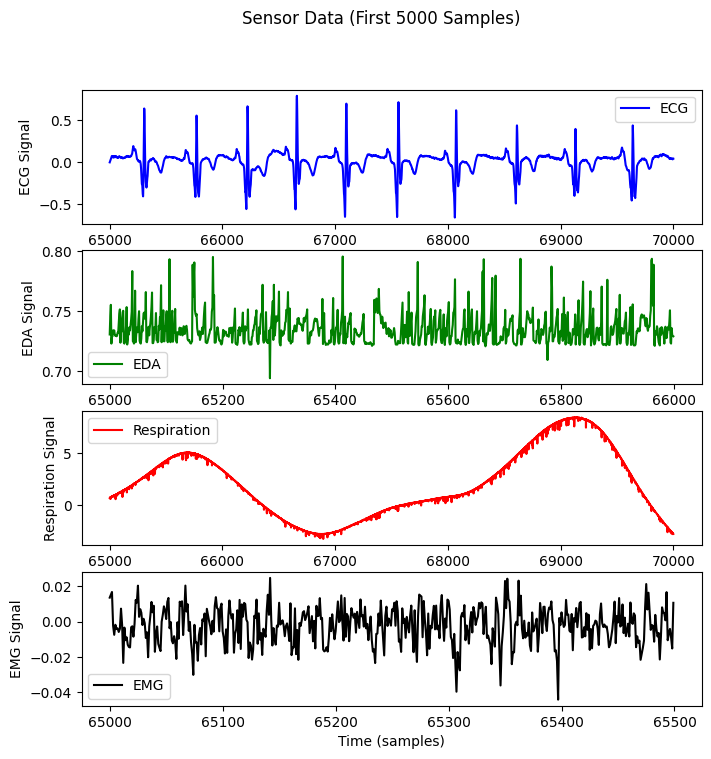

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(4, 1, 1)
plt.plot(df["ECG"][:5000], label="ECG", color="blue")
plt.ylabel("ECG Signal")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df["EDA"][:1000], label="EDA", color="green")
plt.ylabel("EDA Signal")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df["RESP"][:5000], label="Respiration", color="red")
plt.ylabel("Respiration Signal")
plt.xlabel("Time (samples)")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df["EMG"][:500], label="EMG", color="black")
plt.ylabel("EMG Signal")
plt.xlabel("Time (samples)")
plt.legend()

plt.suptitle("Sensor Data (First 5000 Samples)")
plt.show()

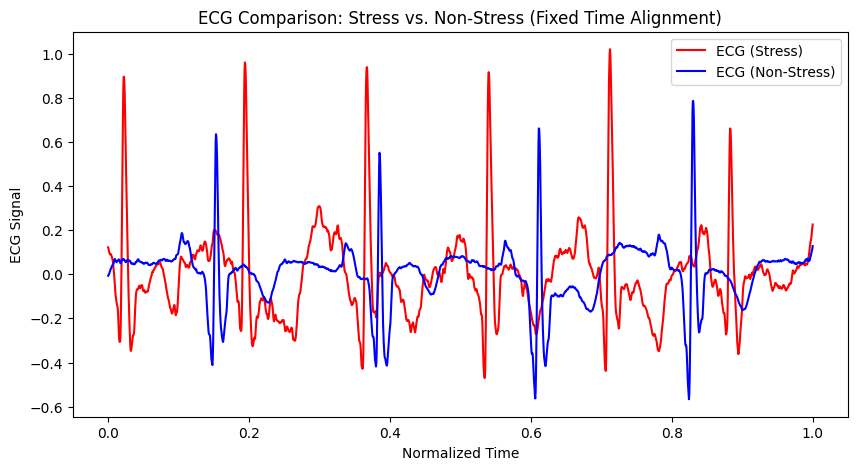

In [18]:
df_stress = df[df["Label"] == 1]  
df_non_stress = df[df["Label"] == 0]
n_samples = 2000
stress_ecg = df_stress["ECG"].values[:n_samples]
non_stress_ecg = df_non_stress["ECG"].values[:n_samples]

time = np.linspace(0, 1, n_samples)

plt.figure(figsize=(10, 5))
plt.plot(time, stress_ecg, label="ECG (Stress)", color="red")
plt.plot(time, non_stress_ecg, label="ECG (Non-Stress)", color="blue")
plt.legend()
plt.xlabel("Normalized Time")
plt.ylabel("ECG Signal")
plt.title("ECG Comparison: Stress vs. Non-Stress (Fixed Time Alignment)")
plt.show()


In [10]:
df['Label'].value_counts()

Label
0    24494402
1     6976201
Name: count, dtype: int64

In [13]:
df.columns

Index(['ECG', 'EDA', 'EMG', 'TEMP', 'RESP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'Label',
       'Subject'],
      dtype='object')

In [15]:
df.shape

(31470603, 10)

# preprocessing

In [12]:
def create_windows(df, window_size=3500, overlap=0.5):
    X, y = [], []
    
    step_size = int(window_size * (1 - overlap))  

    for subject in df['Subject'].unique():  
        sub_df = df[df['Subject'] == subject].reset_index(drop=True)

        sub_data = sub_df[['ECG', 'EDA', 'EMG', 'TEMP', 'RESP', 'ACC_X', 'ACC_Y', 'ACC_Z']].values
        labels = sub_df['Label'].values

        for i in range(0, len(sub_data) - window_size + 1, step_size):  
            X.append(sub_data[i:i + window_size])  
            y.append(np.bincount(labels[i:i + window_size]).argmax())  

    return np.array(X), np.array(y)

In [15]:
X, y = create_windows(df, window_size=3500, overlap=0.5)

In [16]:
print("X shape:", X.shape)    
print("y shape:", y.shape)  

X shape: (17962, 3500, 8)
y shape: (17962,)


In [19]:
num_samples, time_steps, num_features = X.shape
X_flat = X.reshape(-1, num_features) 

In [21]:
X_flat.shape

(62867000, 8)

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(X_flat)

In [24]:
X_scaled = X.reshape(num_samples, time_steps, num_features)  

In [25]:
X_scaled.shape

(17962, 3500, 8)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [88]:
X_train.shape

(14369, 3500, 8)

In [89]:
X_test.shape

(3593, 3500, 8)

In [90]:
y_train

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

> smote to solve imbalance

In [92]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)

In [93]:
X_train_flat.shape

(14369, 28000)

In [94]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_flat, y_train)

In [95]:
X_resampled = X_resampled.reshape(-1, time_steps, num_features)

In [96]:
print("Original class distribution:", dict(pd.Series(y_train).value_counts()))
print("Resampled class distribution:", dict(pd.Series(y_resampled).value_counts()))

Original class distribution: {0: 11186, 1: 3183}
Resampled class distribution: {0: 11186, 1: 11186}


In [97]:
print("X_train shape:", X_resampled.shape) 
print("y_train shape:", y_resampled.shape)


X_train shape: (22372, 3500, 8)
y_train shape: (22372,)


# DL model

In [150]:
model = Sequential([
    Conv1D(filters=16, kernel_size=7, activation='relu', kernel_regularizer=l2(0.001), input_shape=(3500, 8)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=32, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [152]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 3494, 16)       │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3494, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 1747, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1747, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 1743, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1743, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 871, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 871, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 869, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 869, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 434, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 434, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 27776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │       444,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,609 (1.73 MB)

 Trainable params: 454,385 (1.73 MB)

 Non-trainable params: 224 (896.00 B)

In [154]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [156]:
history = model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 92s 139ms/step - accuracy: 0.7233 - loss: 0.5586 - val_accuracy: 0.8155 - val_loss: 0.8641
Epoch 2/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 88s 140ms/step - accuracy: 0.8838 - loss: 0.3084 - val_accuracy: 0.9004 - val_loss: 0.5981
Epoch 3/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 86s 136ms/step - accuracy: 0.9143 - loss: 0.2585 - val_accuracy: 0.9540 - val_loss: 0.2799
Epoch 4/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.9440 - loss: 0.1640 - val_accuracy: 0.9848 - val_loss: 0.0656
Epoch 5/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 75s 118ms/step - accuracy: 0.9484 - loss: 0.1596 - val_accuracy: 0.9710 - val_loss: 0.1040
Epoch 6/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - accuracy: 0.9680 - loss: 0.1076 - val_accuracy: 0.9477 - val_loss: 0.1563
Epoch 7/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 74s 117ms/step - accuracy: 0.9753 - loss: 0.0858 - val_accuracy: 0.9951 - val_loss: 0.0276
Epoch 8/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.9768 - loss: 0

In [158]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9882 - loss: 0.0451
Test Accuracy: 0.9875


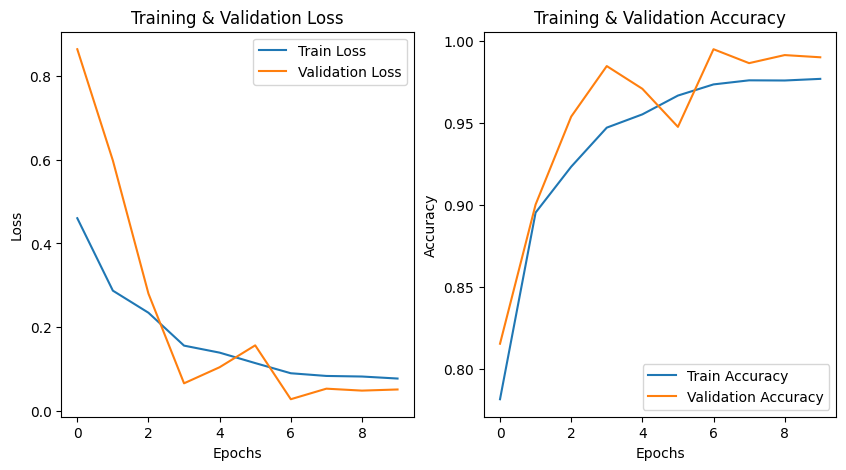

In [159]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [162]:
y_pred = model.predict(X_test)  
y_pred = (y_pred > 0.5).astype(int)  

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [163]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['normal', 'Stress']))


Classification Report:
               precision    recall  f1-score   support

      normal       0.99      0.99      0.99      2797
      Stress       0.97      0.97      0.97       796

    accuracy                           0.99      3593
   macro avg       0.98      0.98      0.98      3593
weighted avg       0.99      0.99      0.99      3593



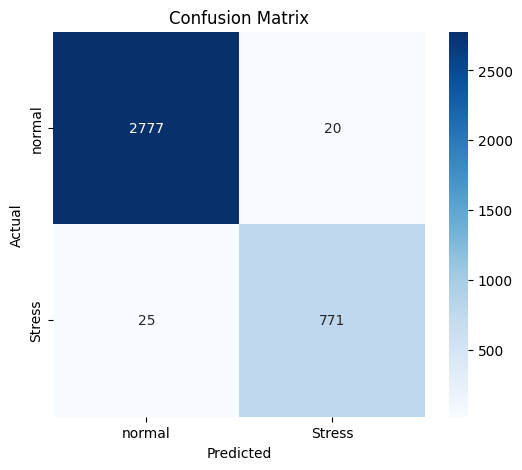

In [166]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'Stress'], 
            yticklabels=['normal', 'Stress'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
